In [3]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# Parameter values
p0 = 101325  # pressure in Pa
T0 = 296  # inlet temperature in K
phi = 0.7  # equivalence ratio
alpha = 0.566  # volume fraction (<1)

# Mass flux (mdot)
mdot_reactants = 80  # kg/m^2/s
mdot_products = mdot_reactants  # kg/m^2/s

# Mechanism and fuel composition
xh2 = alpha / (1 - alpha) * 1  # xh2 = alpha/(1-alpha)*xc
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

# Calculation params
width = 0.1  # m domain width
loglevel = 0  # amount of diagnostic output (0 to 5)

# Gas object 1 for the counterflow flame
gas1 = ct.Solution('gri30.yaml')  # reaction mechanism file
gas1.TP = T0, p0

# Fix the composition of the fuel
gas1.set_equivalence_ratio(phi, fuel, oxidizer)

# Create the counterflow premixed flame simulation object
fl1 = ct.CounterflowPremixedFlame(gas=gas1, width=width)
fl1.transport_model = 'multicomponent'
fl1.energy_enabled = True  # energy equation
fl1.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# Set the boundary flow rates
fl1.reactants.mdot = mdot_reactants
fl1.products.mdot = mdot_products

fl1.set_initial_guess()  # assume adiabatic equilibrium products
fl1.solve(loglevel, auto=True)

# Heat loss coefficient and environment temperature
heat_loss_coefficient = 0.1  # W/m^2·K (example value)
T_env = 300  # K (example value)

# Calculate temperature drop due to heat loss
def calculate_temperature_drop(T_flame, T_env, heat_loss_coefficient):
    # Heat loss calculation
    Q_loss = heat_loss_coefficient * (T_flame - T_env)
    
    # Assuming specific heat and flame density for delta_T calculation
    specific_heat = 1000  # J/kg·K (simplified value)
    flame_density = fl1.density[0]  # kg/m^3
    delta_T = Q_loss / (specific_heat * flame_density)  # Temperature drop
    return delta_T

# Calculate delta_T
delta_T = calculate_temperature_drop(fl1.products.T, T_env, heat_loss_coefficient)

# Gas object 2 for the counterflow flame with non-equilibrium products
gas2 = ct.Solution('gri30.yaml')
gas2.TP = T0, p0
gas2.set_equivalence_ratio(phi, fuel, oxidizer)

# Create the flame simulation object
fl2 = ct.CounterflowPremixedFlame(gas=gas2, width=width)
fl2.transport_model = 'multicomponent'
fl2.energy_enabled = True  # energy equation
fl2.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# Set the boundary flow rates for fl2
fl2.reactants.mdot = mdot_reactants
fl2.products.mdot = mdot_products

# Adjust the product temperature and composition
fl2.products.T = fl1.products.T - delta_T  # Adjust fl2's product temperature
fl2.products.X = fl1.products.X  # Composition of the products

# Solve the flame simulation for fl2 with adjusted temperature
fl2.set_initial_guess(equilibrate=False)
fl2.solve(loglevel, auto=True)
print(f'Adjusted product temperature (fl2): {fl2.products.T:.2f} K')

# Calculate consumption speed for both flames
def calculate_consumption_speed(flame, heat_loss):
    # Get the gas object associated with the flame
    gas = flame.gas
    
    # Apply heat loss to the flame products temperature
    adjusted_temperature = flame.products.T - heat_loss  # Adjust the temperature based on heat loss
    flame.products.T = adjusted_temperature  # Update the products temperature
    
    omega_f = flame.net_production_rates  # Chemical reaction rates for all species
    rho_u = flame.density[0]  # Reactant density
    Y_f_u = flame.Y[0, gas.species_index('CH4')]  # Reactant fuel mass fraction

    # Select reaction rate for CH4
    omega_f_CH4 = omega_f[gas.species_index('CH4'), :]  # Shape: (grid size,)

    # Distance difference in grid
    dx = np.diff(flame.grid)  # Size: (n_grid_points-1)

    # Average omega_f for integration
    omega_avg = 0.5 * (omega_f_CH4[:-1] + omega_f_CH4[1:])  # Average values between grid points

    # Integration
    integral_omega_f = np.sum(omega_avg * dx)  # Integral

    # Calculate consumption speed
    S_cf = -1 / (rho_u * Y_f_u) * integral_omega_f  # Adjust for heat loss

    return S_cf

# Consumption speeds
S_cf_fl1 = calculate_consumption_speed(fl1, delta_T)
S_cf_fl2 = calculate_consumption_speed(fl2, delta_T)

print(f'Consumption speed (S_cf) for fl1: {S_cf_fl1:.6f} m/s')
print(f'Consumption speed (S_cf) for fl2: {S_cf_fl2:.6f} m/s')


Adjusted product temperature (fl2): 1881.86 K
Consumption speed (S_cf) for fl1: 0.135814 m/s
Consumption speed (S_cf) for fl2: 0.135783 m/s


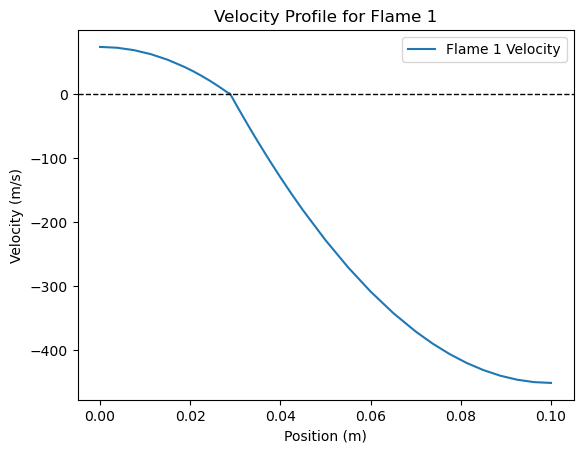

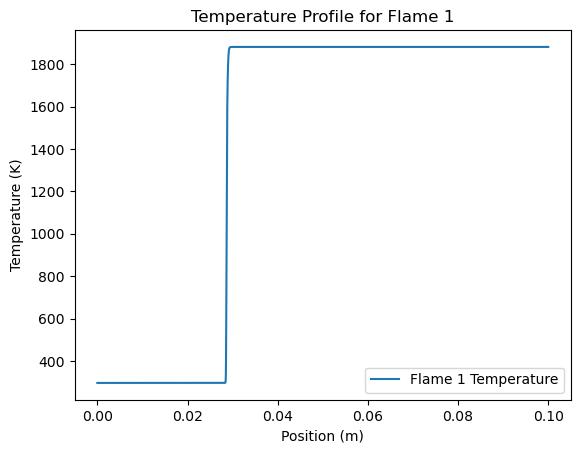

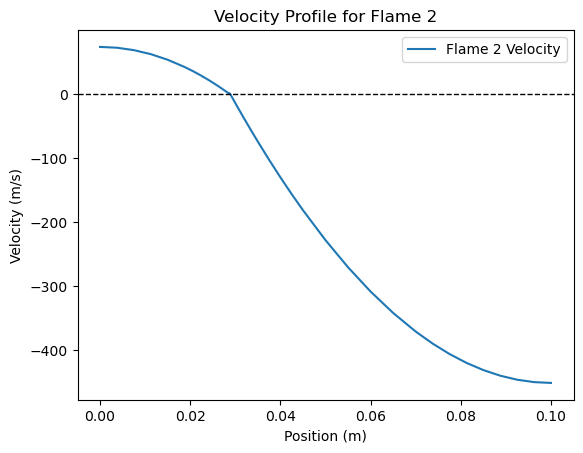

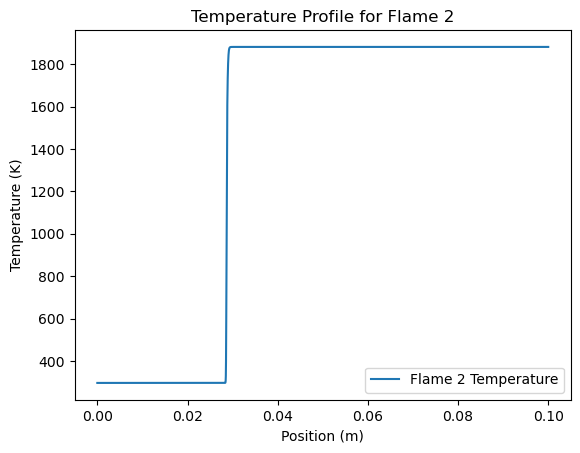

In [4]:
# Plotting velocity and temperature profiles
plt.figure()
plt.plot(fl1.grid, fl1.velocity, label='Flame 1 Velocity')
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)  # stagnation line
plt.title('Velocity Profile for Flame 1')
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

plt.figure()
plt.plot(fl1.grid, fl1.T, label='Flame 1 Temperature')
plt.title('Temperature Profile for Flame 1')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

plt.figure()
plt.plot(fl2.grid, fl2.velocity, label='Flame 2 Velocity')
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)  # stagnation line
plt.title('Velocity Profile for Flame 2')
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

plt.figure()
plt.plot(fl2.grid, fl2.T, label='Flame 2 Temperature')
plt.title('Temperature Profile for Flame 2')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()